Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - band_output_accuracy: 0.0148 - band_output_loss: 2.2162 - cup_output_loss: 10.5526 - cup_output_mae: 2.9774 - loss: 12.7692 - val_band_output_accuracy: 0.0090 - val_band_output_loss: 2.2138 - val_cup_output_loss: 7.5925 - val_cup_output_mae: 2.3812 - val_loss: 9.3623
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - band_output_accuracy: 0.0103 - band_output_loss: 2.2119 - cup_output_loss: 7.1884 - cup_output_mae: 2.4413 - loss: 9.4010 - val_band_output_accuracy: 0.2072 - val_band_output_loss: 2.1819 - val_cup_output_loss: 4.8336 - val_cup_output_mae: 1.8880 - val_loss: 6.8241
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - band_output_accuracy: 0.1205 - band_output_loss: 2.1863 - cup_output_loss: 4.3651 - cup_output_mae: 1.8809 - loss: 6.5522 - val_band_output_accuracy: 0.2613 - val_band_output_loss: 2.1549 - val_cup_output_loss: 2.8676 - val_cup_output_mae: 1.4833 - val_loss: 4.9931
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Band Size Evaluation:
Accuracy: 0.841726618705036
Precision: 0.8291258192031072
Recall: 0.841726618705036

Cup Size Evaluation:
Accuracy: 0.841726618705036
Precision: 0.853712492191121
Recall: 0.841726618705036


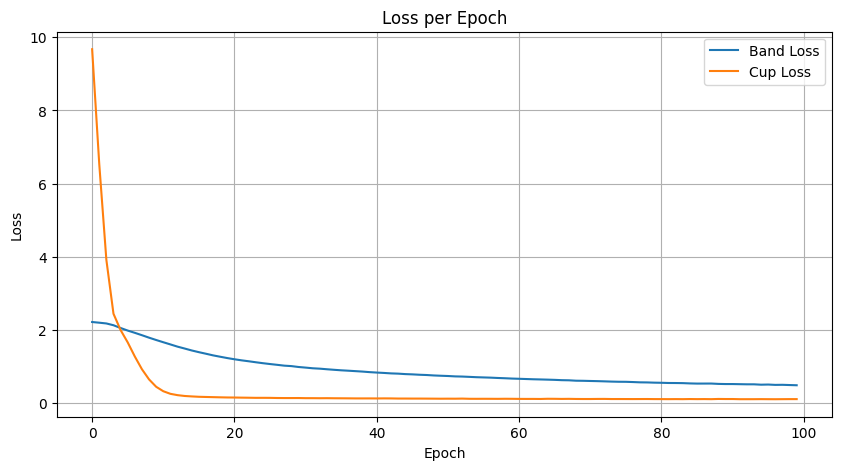

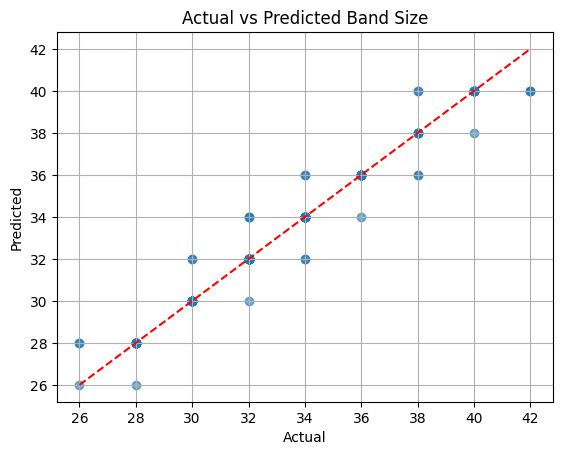

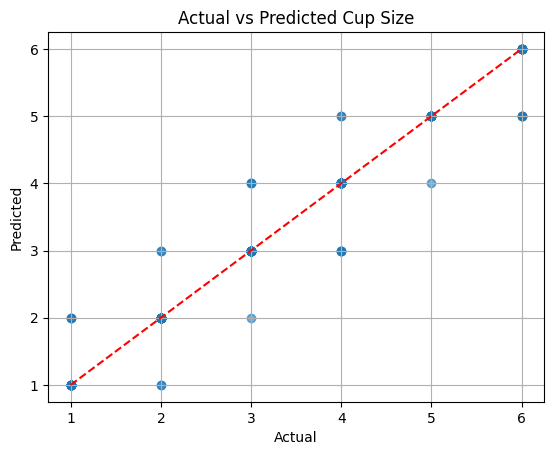

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import joblib

# Load dataset
df = pd.read_csv('training_data.csv')

# Prepare features and labels
X = df.loc[1:, ['height_cm', 'weight_kg', 'body_fat']].values
band_sizes = df.iloc[1:, df.columns.get_loc('band_size')].astype(int).values
cup_sizes = df.iloc[1:, df.columns.get_loc('cup_size_numeric')].astype(int).values

# Encode band sizes as class indices
unique_bands = sorted(list(set(band_sizes)))
band_to_idx = {b: i for i, b in enumerate(unique_bands)}
idx_to_band = {i: b for b, i in band_to_idx.items()}
y_band_class = np.array([band_to_idx[b] for b in band_sizes])

# Normalize inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.pkl")

# Split data
X_train, X_test, y_band_train, y_band_test, y_cup_train, y_cup_test = train_test_split(
    X, y_band_class, cup_sizes, test_size=0.2, random_state=42)

# Model path check
model_path = "bra_model_classified.h5"
if os.path.exists(model_path):
    print("Model already exists. Skipping training.")
    exit()

# Build model
inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(32, activation='relu')(x)
band_output = tf.keras.layers.Dense(len(unique_bands), activation='softmax', name='band_output')(x)  # classification
cup_output = tf.keras.layers.Dense(1, name='cup_output')(x)  # regression

model = tf.keras.Model(inputs=inputs, outputs=[band_output, cup_output])
model.compile(
    optimizer='adam',
    loss={
        'band_output': 'sparse_categorical_crossentropy',
        'cup_output': 'mse'
    },
    metrics={
        'band_output': 'accuracy',
        'cup_output': 'mae'
    }
)

# Train model
history = model.fit(
    X_train,
    {'band_output': y_band_train, 'cup_output': y_cup_train},
    epochs=100,
    validation_split=0.2,
    verbose=1
)

# Predict
band_pred_probs, cup_pred = model.predict(X_test)
band_pred_classes = np.argmax(band_pred_probs, axis=1)
band_pred_actual = np.array([idx_to_band[i] for i in band_pred_classes])
band_test_actual = np.array([idx_to_band[i] for i in y_band_test])
cup_pred = np.round(cup_pred).flatten()

# Evaluation
print("\nBand Size Evaluation:")
print("Accuracy:", accuracy_score(band_test_actual, band_pred_actual))
print("Precision:", precision_score(band_test_actual, band_pred_actual, average='weighted'))
print("Recall:", recall_score(band_test_actual, band_pred_actual, average='weighted'))

print("\nCup Size Evaluation:")
print("Accuracy:", accuracy_score(y_cup_test, cup_pred))
print("Precision:", precision_score(y_cup_test, cup_pred, average='weighted'))
print("Recall:", recall_score(y_cup_test, cup_pred, average='weighted'))

# Save model and mappings
model.save(model_path)
joblib.dump(idx_to_band, "band_mapping.pkl")

# Loss plots
plt.figure(figsize=(10, 5))
plt.plot(history.history['band_output_loss'], label='Band Loss')
plt.plot(history.history['cup_output_loss'], label='Cup Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Prediction plots
plt.figure()
plt.scatter(band_test_actual, band_pred_actual, alpha=0.6)
plt.plot(sorted(set(band_test_actual)), sorted(set(band_test_actual)), 'r--')
plt.title("Actual vs Predicted Band Size")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(y_cup_test, cup_pred, alpha=0.6)
plt.plot([min(y_cup_test), max(y_cup_test)], [min(y_cup_test), max(y_cup_test)], 'r--')
plt.title("Actual vs Predicted Cup Size")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()


In [7]:
import numpy as np
import tensorflow as tf
import joblib

# Load model without compiling to avoid the 'mse' function deserialization issue
model = tf.keras.models.load_model("bra_model_classified.h5", compile=False)

# Load scaler and band mapping
scaler = joblib.load("scaler.pkl")
band_mapping = joblib.load("band_mapping.pkl")  # This is idx_to_band
idx_to_band = band_mapping

# Get user input
def get_user_input():
    try:
        height = float(input("Enter height (cm): "))
        weight = float(input("Enter weight (kg): "))
        body_fat = float(input("Enter body fat percentage: "))
        return np.array([[height, weight, body_fat]])
    except ValueError:
        print("Invalid input. Please enter numeric values.")
        return get_user_input()

# Preprocess input
X_new = get_user_input()
X_scaled = scaler.transform(X_new)

# Predict
band_probs, cup_pred = model.predict(X_scaled)
band_class = np.argmax(band_probs[0])
band_size = idx_to_band[band_class]
cup_numeric = round(cup_pred[0][0])

# Map numeric cup size back to letter
cup_letters = {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'DD', 6: 'E', 7: 'F'}
cup_letter = cup_letters.get(cup_numeric, f"Unknown({cup_numeric})")

# Display result
print(f"\nPredicted Bra Size: {band_size}{cup_letter}")


Enter height (cm): 162
Enter weight (kg): 51
Enter body fat percentage: 23.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Predicted Bra Size: 30A
